In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import spacy
import contractions
import seaborn as sns
import os
import dill
import joblib
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm_notebook
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report,confusion_matrix, accuracy_score, 
                             precision_score, f1_score, recall_score, precision_recall_curve, 
                             auc, log_loss, roc_curve, roc_auc_score)
from preprocess_functions import *

plt.style.use('rose-pine')
tqdm_notebook.pandas()    #<-- activate tqdm for pandas.apply() functions

warnings.filterwarnings('ignore')

#### READING IN THE DATASETs

In [2]:
regulations = pd.read_csv(r"C:\Users\USER\Desktop\vicko-20230316T180337Z-001\vicko\AI Mentorship\finaincial_doc_labelling_pipeline\data\regulations.csv")
relevance_data = pd.read_csv(r"C:\Users\USER\Desktop\vicko-20230316T180337Z-001\vicko\AI Mentorship\finaincial_doc_labelling_pipeline\data\relevance_data.csv")

In [3]:
# change the column name cases to lower case to reduce risk of case sensitive errors

regulations.columns = regulations.columns.str.lower()
relevance_data.columns = relevance_data.columns.str.lower()

##### EDA

In [4]:
print(f'Regulations data: {regulations.shape}')
print(f'Relevance data: {relevance_data.shape}')

Regulations data: (134083, 8)
Relevance data: (100000, 4)


In [5]:
print("_____________________Regulations Data___________________")
print(regulations.info())
print("_____________________Relevance Data_____________________")
print(relevance_data.info())

_____________________Regulations Data___________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134083 entries, 0 to 134082
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            133687 non-null  object
 1   regulatorid      134083 non-null  object
 2   sourcelanguage   134083 non-null  object
 3   documenttypeid   134083 non-null  object
 4   publicationdate  134083 non-null  object
 5   ispdf            134083 non-null  bool  
 6   content          133480 non-null  object
 7   documentid       134083 non-null  object
dtypes: bool(1), object(7)
memory usage: 7.3+ MB
None
_____________________Relevance Data_____________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   requirementsource           100000

In [6]:
regulations.describe()

,title,regulatorid,sourcelanguage,documenttypeid,publicationdate,ispdf,content,documentid
count,133687,134083,134083,134083,134083,134083,133480,134083
unique,81406,868,124,117,39546,2,93569,97584
top,ADDENDUM AND NOTICE IN ADDITION TO SUPPLEMENT ...,591c-e7a9-4783-a908-6ed20f4b,English,755e-aec5-4995-9047-aaeb9074,2021-10-29 17:28:35.843333+00:00,False,Not machine-readable,9d6f-d488-43a1-baea-feeb9d64
freq,628,12786,40839,24690,10900,72937,596,157


In [7]:
relevance_data.describe()

,requirementsource,containsrelevantregulation,user,documentid
count,100000,100000,100000,100000
unique,2,2,157,78274
top,Guidance,False,000006A5,706f-1dad-4738-9d77-cf09c5e4
freq,55597,90080,16203,4


A quick look into the 2 regulations and relevance_data datasets have given a brief overview what each that looks like by their columns. 

- A unique `DocumentID` count of `78274` suggests that there duplicates in the relevance_data as well as the unique statistics in the regulations data. 

- While these documents have are written in `124` different languages, `English` documents appears to be the most represented with a total of `40839`.

- Over 50% of the documents are for `Guidance` and not actual regulations.

- Less than 10% of the labelled documents are considered relevant to Financial law. This already draws attention to the presence of class imbalance. 

In [8]:
# Drop duplicates

def remove_duplicate(df, holdout_set = None):
    """
    Detect and remove duplicate rows in the dataset.
    """
    b4 = df.shape[0]
    print(f'{holdout_set} -- Before Removing Duplicate: {b4:,}')
    df.drop_duplicates(keep='first', inplace=True)
    after = df.shape[0]
    print (f'{holdout_set} -- After Removing Duplicate: {after:,}', '\n')

    if b4 == after:
        print(f"There are no duplicate rows in the {holdout_set}", '\n')
    else:
        print(str(b4 - after) + ' ' + "duplicate row(s) has been removed")


remove_duplicate(regulations, 'Regulations Data')
print("\n\n")
remove_duplicate(relevance_data, 'Relevance Data')

Regulations Data -- Before Removing Duplicate: 134,083
Regulations Data -- After Removing Duplicate: 97,590 

36493 duplicate row(s) has been removed



Relevance Data -- Before Removing Duplicate: 100,000
Relevance Data -- After Removing Duplicate: 100,000 

There are no duplicate rows in the Relevance Data 



#### Splitting between Train(LABELLED) and Test(UNLABELLED) 

In [9]:
labelled_ids = list(relevance_data.documentid.unique())

train = regulations[regulations['documentid'].isin(labelled_ids)]
test = regulations[~regulations['documentid'].isin(labelled_ids)]
print(f'Original data: {regulations.shape}')
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}')


Original data: (97590, 8)
Train data: (77724, 8)
Test data: (19866, 8)


In [61]:
# save test data to file
test.to_csv('test.csv', index = False)

In [10]:
train = train.merge(relevance_data, on='documentid')

print(f'Train data: {train.shape}')


Train data: (99277, 11)


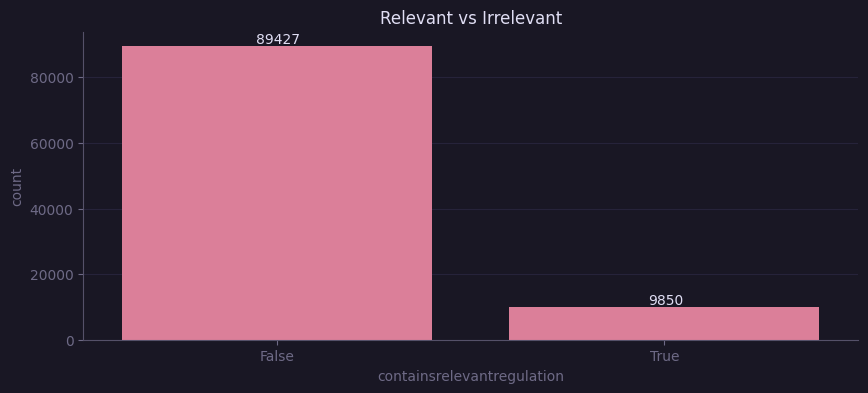

In [11]:
plt.figure(figsize=(10,4))
ax = sns.countplot(train, x = 'containsrelevantregulation')
for p in ax.patches:
    x = p.get_x() + p.get_width()/2
    y = int(p.get_height())
    ax.annotate(text = y, xy = (x,y), ha = 'center', va = 'center', xytext = (1,5), textcoords = 'offset points')

plt.title('Relevant vs Irrelevant');

The above barchart above visualizes the fourth observation from the EDA carried out above. The regulations dataset is dominated by documents that are not relevant to fianancial law. An imbalance like this would affect the models performace as it would most likely perform well when predicting `irrelevant` label. To handle this some techniques will be applied to handle this.

In [12]:
# Extract week of the month in which document was released.

def week_of_month(date):
    date = pd.to_datetime(date)  # Ensure date is a datetime object
    first_day = date.replace(day=1)
    dom = date.day
    adjusted_dom = dom + first_day.weekday()  # Adjust day of month for the first day of the week
    return int(np.ceil(adjusted_dom / 7.0))

train['week'] = train['publicationdate'].apply(week_of_month)

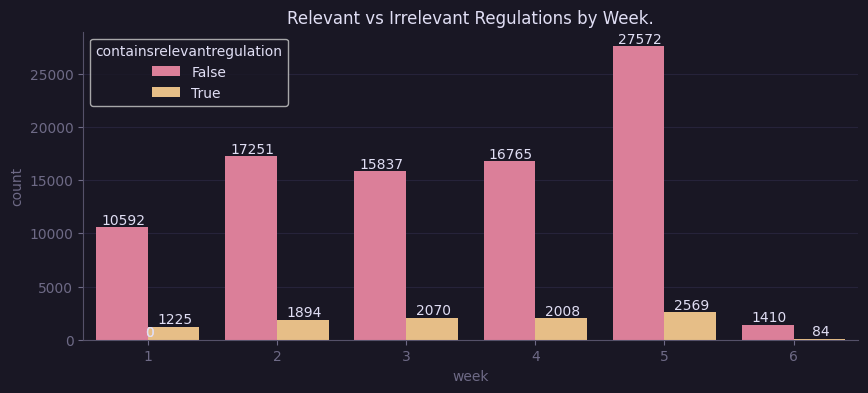

In [13]:
plt.figure(figsize=(10,4))
ax = sns.countplot(train, x = 'week', hue='containsrelevantregulation')
for p in ax.patches:
    x = p.get_x() + p.get_width()/2
    y = int(p.get_height())
    ax.annotate(text = y, xy = (x,y), ha = 'center', va = 'center', xytext = (1,5), textcoords = 'offset points')

plt.title('Relevant vs Irrelevant Regulations by Week.');

While it is aready an established fact that documents labelled `irrelevant` to financial law dominate the data set, we can see how they are published by the weeks of the month. With `27571` documents labelled `irrelevant`, the `5th week` week of the month is the peak period for publications. The `5th week` also recorded the highest number of `relevant` regulation documents. Understabably, the `6th week` emerges as the week with the least publications. This is most likely due to the fact that most moths do not spread across 6 weeks.

#### Feature Enginering

In [14]:
# Commbine Title and Content into one column for easy text preprocessing
train['title_and_content'] = train['title'] + ' ' + train['content']

# Drop Title, Publicationdate Content Columns from the train and check for duplicates
train.drop(['title', 'publicationdate','content'], axis=1, inplace=True)

remove_duplicate(train, 'Train Data')

Train Data -- Before Removing Duplicate: 99,277
Train Data -- After Removing Duplicate: 99,273 

4 duplicate row(s) has been removed


In [15]:
# Replace missing values with 'Missing'
train['title_and_content'].fillna('Missing', inplace=True) 

C:\Users\USER\AppData\Local\Temp\ipykernel_23668\3718033484.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['title_and_content'].fillna('Missing', inplace=True)


##### Creating Some Helper Functions

- Here the newly created `title_and_content` columns will be cleaned and preprocessed. 

In [3]:
# def expand_contractions(text):
#     """
#     Expand literal word contractions (e.g I'm not happy --> I am not happy. It's terrible --> It is terrible)
#     """
#     expanded_contraction = contractions.fix(text, slang=False)
#     return expanded_contraction


# def clean_words(text):
#     """
#     Clean the text in the News Article
#     """
#     text = re.sub(r"[^a-zA-Z ]+", " ", text.strip())         #<--- remove non-alphabetic words
#     text = re.sub(r'\w*\d\w*', '', text)                     #<--- Remove alphanumeric words
#     text = re.sub(r"\s{2,}", " ", text)                      #<--- Replace multiple spaces with a single space
#     text = re.sub(r"https?://\S+|www\.\S+", "", text)        #<--- Remove URLs (http/https and www)
#     text = re.sub('<.*?>', '', text)                         #<--- Remove HTML tags
    
    
#     text = ''.join([char for char in text if char not in string.punctuation])     #<--- Remove punctuation
#     text = text.replace('\n', ' ')                                                #<--- Remove newline characters
    
#     return text


# def tokenize(text):
#     """
#     Tokenize the input text.
#     Args:
#         text (str): The input text to be tokenized.
#     Returns:
#         str: A space-separated string of tokens.
#     Example:
#         >>> text = "This is a sample sentence."
#         >>> tokenize(text)
#         ['This', 'is', 'a', 'sample', 'sentence', '.']
#     """
#     lowercase = text.lower()                           #<--- Convert text to lower case
#     tokens = word_tokenize(lowercase)                  #<--- Perform tokenization
#     return (" ".join(tokens)).strip()                  #<--- Join tokens with spaces and strip extra spaces


# def remove_stopwords(text):
#     """
#     Remove stopwords from the input text.
#     """
#     nltk_stop_words = nltk.corpus.stopwords.words('english')                    #<--- Get the list of English stopwords
#     word_list = [word for word in text.split() if word not in nltk_stop_words]  #<--- Remove stopwords from the text
#     return " ".join(word_list)                                                  #<--- Join remaining words into a string


# def lemmatize(text):
#     """
#     Lemmatize the words in the input text.
#     """
#     lemma = WordNetLemmatizer()                                        #<--- Initialize the WordNet lemmatizer
#     lemmatized = [lemma.lemmatize(word) for word in text.split()]      #<--- Lemmatize each word in the text
#     return " ".join(lemmatized)                                        #<--- Join the lemmatized words into a string


# def preprocess_text(text):
#     """
#     Preprocesses the input text using a series of text cleaning and normalization steps.
#     Args:
#         text (str): The input text to be preprocessed.
#     Returns:
#         str: Preprocessed text.
#     """
#     # print(f"Type of input text: {type(text)}")

#     text = expand_contractions(text)
#     text = clean_words(text)
#     text = tokenize(text)
#     text = remove_stopwords(text)
#     text = lemmatize(text)
    
#     return text

def preprocess_data(text_series):
    """
    Preprocesses the input text using a series of text cleaning and normalization steps.
    Args:
        text_series (pd.Series or str): The input text to be preprocessed.
    Returns:
        pd.Series or str: Preprocessed text.
    """
    if isinstance(text_series, pd.Series):
        return text_series.apply(lambda text: preprocess_text(text))
    elif isinstance(text_series, str):
        return preprocess_text(text_series)
    else:
        raise ValueError("Input must be a pandas Series or a string.")


### Data Preprocessing

In [18]:
# Applying helper functions to the title_and_content 
train['title_and_content'] = train['title_and_content'].progress_apply(preprocess_data)

In [7]:
# train.to_csv("train_data.csv", index = False)

In [4]:
train = pd.read_csv('train_data.csv')


In [5]:
train['title_and_content'].fillna('Missing', inplace=True) 

In [6]:
# Convert week dtype to categorical so the model does not mistake the classes for numerical or having order
train['week'] = train['week'].astype('category')

In [7]:
# Separate columns into groups by types
low_cardinality = ['requirementsource','ispdf', 'week']
high_cardinality = ['regulatorid','sourcelanguage','documenttypeid','documentid', 'user']
text_column = ['title_and_content']

print("Low cardinality cols for One-Hot Encoding: \n", low_cardinality)
print("\n")
print("High cardinality cols for Label Encoding: \n", high_cardinality)
print("\n")
print("Text Columns: \n", text_column)

Low cardinality cols for One-Hot Encoding: 
 ['requirementsource', 'ispdf', 'week']


High cardinality cols for Label Encoding: 
 ['regulatorid', 'sourcelanguage', 'documenttypeid', 'documentid', 'user']


Text Columns: 
 ['title_and_content']


Because of the variation in cardinalities amongst the categorical variables, the categorical variables will be handled differently. Variables such as `requirementsource and ispdf` have low cardinality (just 2 categories) and becasue of this, `One-Hot Encoding` will be applied to them since low cardinality reduces the risk of overfitting. While variables such as  `regulatorid, sourcelanguage, documenttypeid, documentid and user` will require `Ordinal Encoder` for encoding. With this approach, we are less likely to have our model overfit.

In [8]:
train['containsrelevantregulation'].value_counts()

containsrelevantregulation
False    89423
True      9850
Name: count, dtype: int64

In [9]:
# Split into training and validation sets

X = train.drop('containsrelevantregulation', axis=1)
y = train['containsrelevantregulation']

# train = train[:1000]
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
train_data, val_data = train_test_split(train, test_size = 0.2, shuffle = True, random_state = 42)

##### Handling Class Imbalance.

As stated in the EDA part pf this project, there would be need to handle class imbalance. 

In [10]:
minority_class = train[train['containsrelevantregulation'] == True]
majority_class = train[train['containsrelevantregulation'] == False]

balanced_data = minority_class.sample(n = len(majority_class), replace = True, random_state = 42)
train_data = pd.concat([balanced_data, majority_class])
imbalance = train_data['containsrelevantregulation'].value_counts()
print(f'Balanced Traget Column: {imbalance}')

Balanced Traget Column: containsrelevantregulation
True     89423
False    89423
Name: count, dtype: int64


In [11]:
X_train = train_data[text_column + high_cardinality + low_cardinality]
y_train = train_data['containsrelevantregulation']

X_val = val_data[text_column + high_cardinality + low_cardinality]
y_val = val_data['containsrelevantregulation']

In [12]:
# Instantiating the models
lr_model = LogisticRegression()
# svc_model = SVC(probability = True)
xgb_model = XGBClassifier()
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
dt_model = DecisionTreeClassifier()

In [13]:
# encoders
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
text_vectorizer = TfidfVectorizer(max_features = 2000, min_df = 5, max_df = 0.7, ngram_range = (1,2))

categorical_imputer = SimpleImputer(strategy='constant', fill_value='Missing')

# add the preprocess_data func to a FunctionTransformer
text_preprocessor_transformer = FunctionTransformer(preprocess_data, validate=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', Pipeline(steps=[
            ('imputer', categorical_imputer),
            ('encoder', one_hot_encoder)
        ]), low_cardinality),

        ('ordinal', Pipeline(steps=[
            ('imputer', categorical_imputer),
            ('encoder', ordinal_encoder)
        ]), high_cardinality),

        ('text', Pipeline(steps=[
            ('text_preprocessor', text_preprocessor_transformer), # Using FunctionTransformer
            ('vectorizer', text_vectorizer)
        ]), 'title_and_content'),
    ],
    remainder='passthrough'  # Pass through other columns unchanged
)


In [14]:
# fit train and transform validation set
X_train_preprocessed = preprocessor.fit_transform(X_train) 
X_val_preprocessed = preprocessor.transform(X_val)

#### Creating Helper Functions 

In [15]:
def save_to_dir(file_name):
    current_dir = os.getcwd()

    # Navigate one level up to financial_doc_labelling_pipeline
    parent_dir = os.path.dirname(current_dir)

    # Define the path to the evaluation_metrics directory
    evaluation_metrics_dir = os.path.join(parent_dir, 'evaluation_metrics')

    # Create the directory if it doesn't exist
    if not os.path.exists(evaluation_metrics_dir):
        os.makedirs(evaluation_metrics_dir)

    # Define the full file path for saving the image
    # classifier = 'example_classifier'  # Replace with your classifier name variable
    file_path = os.path.join(evaluation_metrics_dir, file_name)

    # Save the plot
    plt.savefig(file_path)



In [16]:
def save_model_to_dir(model_name, model):
    current_dir = os.getcwd()

    # Navigate one level up to the parent directory
    parent_dir = os.path.dirname(current_dir)

    # Define the path to the models directory
    models_dir = os.path.join(parent_dir, 'models')

    # Create the directory if it doesn't exist
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    # Define the full file path for saving the model
    file_path = os.path.join(models_dir, model_name)

    # Save the model to the specified path using joblib
    joblib.dump(model, file_path)
    print(f'Model saved as {file_path}')



def load_model_from_dir(model_name):
    current_dir = os.getcwd()

    # Navigate one level up to the parent directory
    parent_dir = os.path.dirname(current_dir)
    models_dir = os.path.join(parent_dir, 'models')
    file_path = os.path.join(models_dir, model_name)
    
    # Check if the model file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The model file {model_name} does not exist in the directory {models_dir}.")

    # Load the model from the specified path using joblib
    model = joblib.load(file_path)
    print(f"Model loaded from {file_path}")
    
    return model

In [17]:
metrics_df = pd.DataFrame(columns = ['model', 'train_accuracy','val_accuracy', 'precision', 'recall', 'f1', 'logloss', 'roc'])

y_pred, y_pred_proba = 0, 0 

# Plot confusion matrix
def plot_confusion_matrix(classifier,y_val, ypred):
    plt.style.use('rose-pine-moon')
    sns.heatmap(confusion_matrix(y_val, ypred, normalize='true'), annot = True, cbar=False)
    plt.title(f'{classifier} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # plt.savefig(f'{classifier}_cf_matrix.png')
    save_to_dir(f'{classifier}_cf_matrix.png')
    plt.show();

# plot precision_recall_curve
def plot_precision_recall_curve(classifier,y_val, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
    
    auc_pr = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', label=f'Precision-Recall Curve (AUC-PR = {auc_pr:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{classifier} Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    # plt.savefig(f'{classifier}_precision_recall_curve.png') 
    save_to_dir(f'{classifier} Precision-Recall Curve') 
    plt.show()

# PLot roc_curve
def plot_roc_curve(classifier,y_val, y_pred_proba):
    with plt.style.context('rose-pine-moon'):
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
        roc = roc_auc_score(y_val, y_pred_proba)
        plt.figure(figsize=(8, 4))
        plt.plot([0, 1], [0, 1], 'y--', label = 'Random Guess')
        plt.plot(fpr, tpr, lw=2, marker='.', color='blue', label='ROC Curve Area')
        plt.annotate(f"AUC = {roc:.2f}", xy=(0.7, 0.5), fontsize=12)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{classifier} ROC Curve')
        plt.legend(loc='best')
        # plt.savefig(f'{classifier}_roc_curve.png')
        save_to_dir(f'{classifier}_roc_curve.png')
        plt.show()

# Compute evaluation metrics
def compute_eval_metrics(y_val, ypred, ypred_train, ytrain=None):
    accuracy = accuracy_score(y_val, ypred)
    precision = precision_score(y_val, ypred)
    recall = recall_score(y_val, ypred)
    f1 = f1_score(y_val, ypred)
    logloss = log_loss(y_val, ypred)
    roc = roc_auc_score(y_val, y_pred_proba)
     
    if ytrain is not None:
        accu_train = accuracy_score(ytrain, ypred_train) 
        
        return accu_train, accuracy, precision, recall, f1, logloss, roc
    

# Fit model, predict and call the eval metric funcs and plot funcs 
def train_predict_plot(model,classifier, xtrain, ytrain, xval = X_val, y_val = y_val):

    model.fit(xtrain, ytrain)
    
    # Save the fitted model
    model_filename = f'{classifier}_model.pkl'
    save_model_to_dir(model_filename, model)

    global y_pred, y_pred_proba  

    y_pred_train = model.predict(xtrain)
    y_pred = model.predict(xval)
    y_pred_proba = model.predict_proba(xval)[:, 1]    
    
    train_accu, val_accu, precision, recall, f1, logloss, roc = compute_eval_metrics(y_val, y_pred, y_pred_train, y_train)
    metrics_df.loc[len(metrics_df.index)] = (classifier,train_accu,val_accu, precision, recall, f1, logloss, roc)
    
    print(f'Train Accuracy: {train_accu:.2f} | Val Accuracy: {val_accu:.2f} | Precision: {precision:.2f}', 
          f'| Recall: {recall:.2f} | F1-Score: {f1:.2f} | Log_Loss {logloss:.2f} | ROC-Auc-Score: {roc:.2f}')

    plot_confusion_matrix(classifier, y_val, y_pred)
    plot_precision_recall_curve(classifier, y_val, y_pred_proba)
    plot_roc_curve(classifier, y_val, y_pred_proba)

    return {'Train Accuracy': round(train_accu, 2),
            'Test Accuracy': round(val_accu, 2),
            'Precision': round(precision, 2), 
            'Recall': round(recall, 2), 
            'F1-Score': round(f1, 2),
            'Log_loss': round(logloss,2),
            'Roc_Auc_Score': round(roc, 2)}

#### Training And Testing Models

Model saved as c:\Users\USER\Desktop\vicko-20230316T180337Z-001\vicko\AI Mentorship\finaincial_doc_labelling_pipeline\models\RandomForestClassifier_model.pkl
Train Accuracy: 1.00 | Val Accuracy: 1.00 | Precision: 0.99 | Recall: 1.00 | F1-Score: 1.00 | Log_Loss 0.03 | ROC-Auc-Score: 1.00


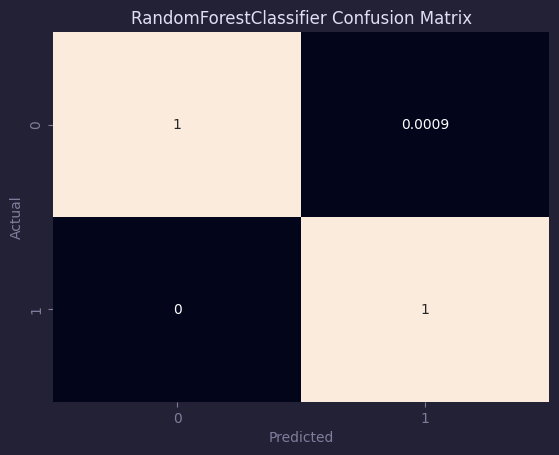

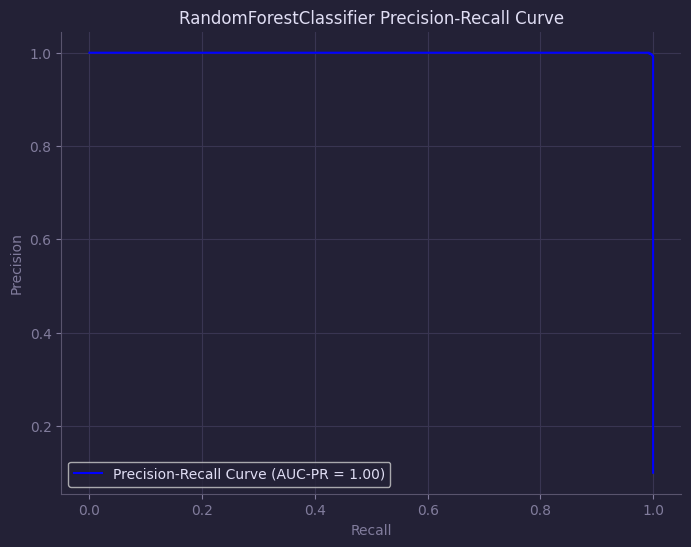

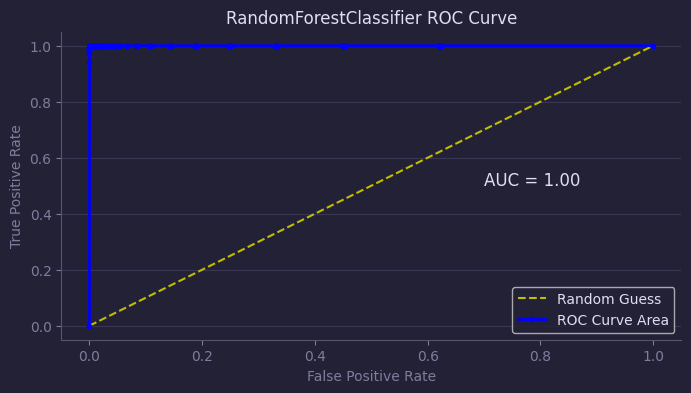

{'Train Accuracy': 1.0,
 'Test Accuracy': 1.0,
 'Precision': 0.99,
 'Recall': 1.0,
 'F1-Score': 1.0,
 'Log_loss': 0.03,
 'Roc_Auc_Score': 1.0}

In [18]:
train_predict_plot(rf_model, 'RandomForestClassifier', X_train_preprocessed, y_train, X_val_preprocessed, y_val)

Model saved as c:\Users\USER\Desktop\vicko-20230316T180337Z-001\vicko\AI Mentorship\finaincial_doc_labelling_pipeline\models\LogisticRegression_model.pkl
Train Accuracy: 0.70 | Val Accuracy: 0.67 | Precision: 0.19 | Recall: 0.72 | F1-Score: 0.30 | Log_Loss 11.91 | ROC-Auc-Score: 0.74


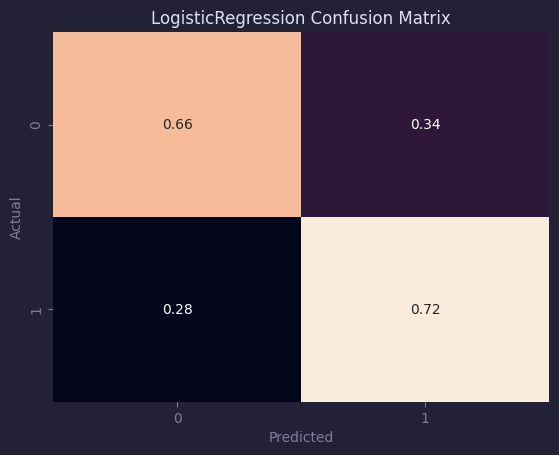

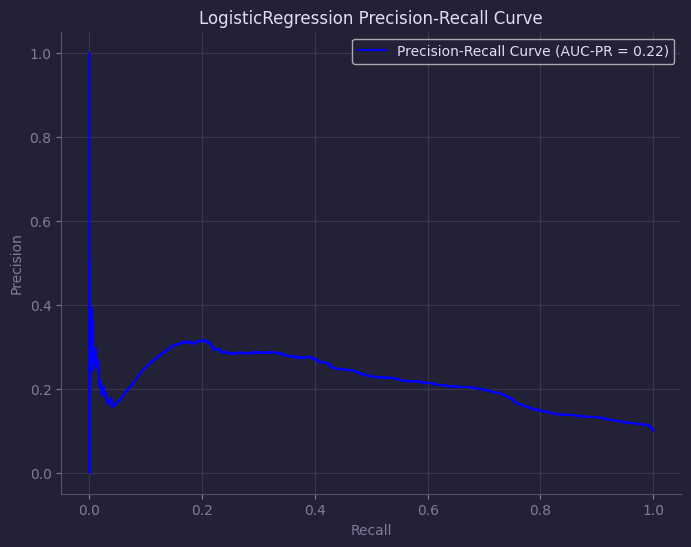

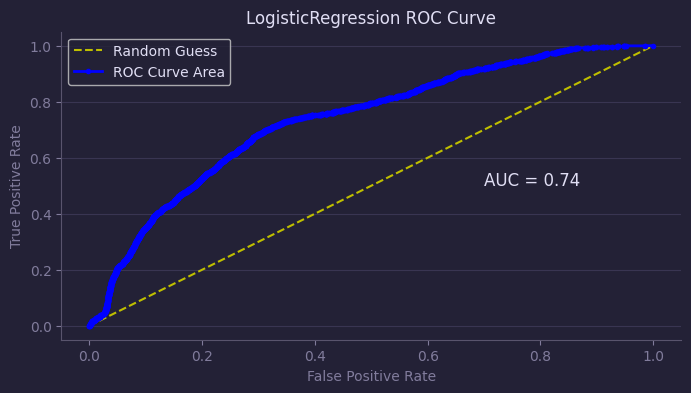

{'Train Accuracy': 0.7,
 'Test Accuracy': 0.67,
 'Precision': 0.19,
 'Recall': 0.72,
 'F1-Score': 0.3,
 'Log_loss': 11.91,
 'Roc_Auc_Score': 0.74}

In [19]:
train_predict_plot(lr_model, 'LogisticRegression', X_train_preprocessed, y_train, X_val_preprocessed, y_val)

Model saved as c:\Users\USER\Desktop\vicko-20230316T180337Z-001\vicko\AI Mentorship\finaincial_doc_labelling_pipeline\models\XGBClassifier_model.pkl
Train Accuracy: 0.96 | Val Accuracy: 0.95 | Precision: 0.67 | Recall: 0.98 | F1-Score: 0.80 | Log_Loss 1.80 | ROC-Auc-Score: 0.99


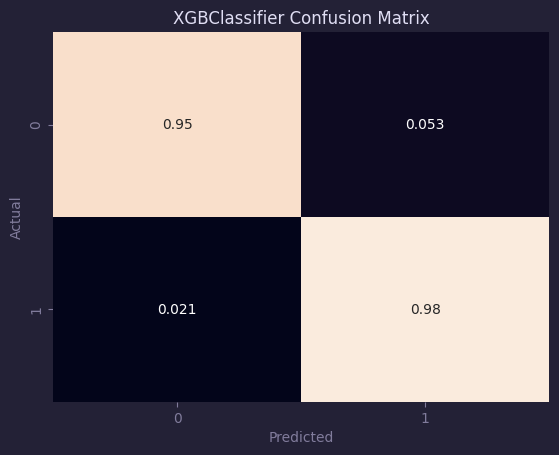

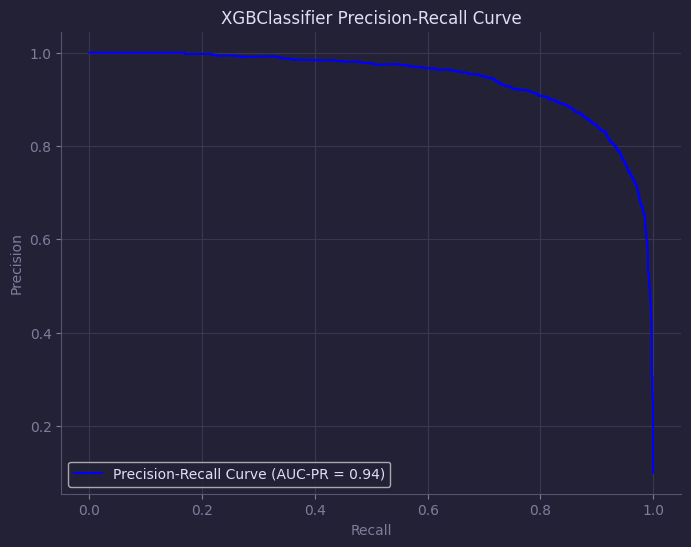

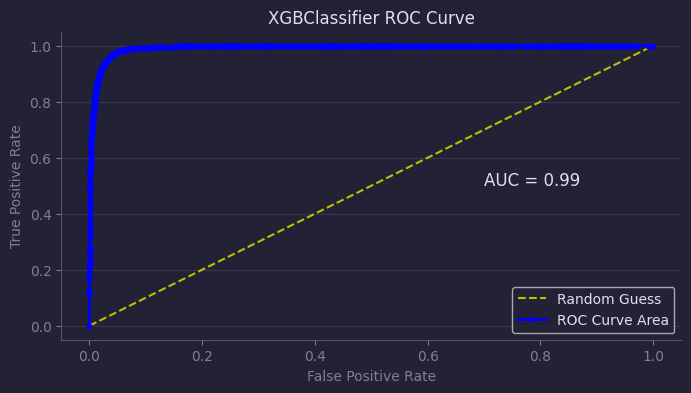

{'Train Accuracy': 0.96,
 'Test Accuracy': 0.95,
 'Precision': 0.67,
 'Recall': 0.98,
 'F1-Score': 0.8,
 'Log_loss': 1.8,
 'Roc_Auc_Score': 0.99}

In [20]:
train_predict_plot(xgb_model, 'XGBClassifier', X_train_preprocessed, y_train, X_val_preprocessed, y_val)

In [21]:
# train_predict_plot(dt_model, 'DecisionTreeClassifier', X_train_preprocessed, y_train, X_val_preprocessed, y_val)

In [22]:
# train_predict_plot(knn_model, 'KNeighborsClassifier', X_train_preprocessed, y_train, X_val_preprocessed, y_val)

In [24]:
metrics_df

,model,train_accuracy,val_accuracy,precision,recall,f1,logloss,roc
0,RandomForestClassifier,0.999575,0.999194,0.992000,1.000000,0.995984,0.029046,0.999997
1,LogisticRegression,0.695543,0.669554,0.191701,0.717238,0.302541,11.910471,0.735714
2,XGBClassifier,0.964478,0.950189,0.672086,0.979335,0.797128,1.795375,0.992810


#### Model Pipeline

In [25]:
best_model = load_model_from_dir('RandomForestClassifier_model.pkl')

pipeline = Pipeline([
    ('data_preprocessing', preprocessor),
    ('model', best_model)
])

from sklearn import set_config
set_config(display = 'diagram')
pipeline

Model loaded from c:\Users\USER\Desktop\vicko-20230316T180337Z-001\vicko\AI Mentorship\finaincial_doc_labelling_pipeline\models\RandomForestClassifier_model.pkl


Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['requirementsource', 'ispdf',
                                                   'week']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer...
                                                                                  unknown_value=-1))]),
                                                  ['regulatorid',
                                                   'sourcelanguage',
                                                   'documenttypeid',
                                                   'documentid', 'user']),
                                                 ('text',
                                                  Pipeline(steps=[('text_preprocessor',
                                                                   FunctionTransformer(func=<function preprocess_data at 0x00000204E1D96DE0>)),
                                                                  ('vectorizer',
                                                                   TfidfVectorizer(max_df=0.7,
                                                                                   max_features=2000,
                                                                                   min_df=5,
                                                                                   ngram_range=(1,
                                                                                                2)))]),
                                                  'title_and_content')])),
                ('model', RandomForestClassifier())])

#### Save pipeline to models dir

In [26]:
def save_pipeline_to_dir(model_name, model):
    current_dir = os.getcwd()

    # Navigate one level up to the parent directory
    parent_dir = os.path.dirname(current_dir)
    models_dir = os.path.join(parent_dir, 'models')

    # Create the directory if it doesn't exist
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    # Define the full file path for saving the model
    file_path = os.path.join(models_dir, model_name)

    # Save the pipeline using dill
    try:
        with open(file_path, 'wb') as f:
            dill.dump(model, f)
        print(f'Pipeline saved successfully as {file_path}')
    except Exception as e:
        print(f'Failed to save pipeline: {e}')


def load_model_from_dir(model_name):
    current_dir = os.getcwd()

    # Navigate one level up to the parent directory
    parent_dir = os.path.dirname(current_dir)
    models_dir = os.path.join(parent_dir, 'models')
    file_path = os.path.join(models_dir, model_name)
    
    # Check if the model file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The model file {model_name} does not exist in the directory {models_dir}.")

    # Load the model from the specified path using dill
    try:
        with open(file_path, 'rb') as f:
            model = dill.load(f)
        print(f"Model loaded from {file_path}")
    except Exception as e:
        raise RuntimeError(f"Failed to load model: {e}")
    
    return model        

In [27]:
save_pipeline_to_dir('document_classifier.dill', pipeline)

Pipeline saved successfully as c:\Users\USER\Desktop\vicko-20230316T180337Z-001\vicko\AI Mentorship\finaincial_doc_labelling_pipeline\models\document_classifier.dill


#### Making Prediction On The Test Set

In [28]:
pipeline_1 = load_model_from_dir('document_classifier.dill')

Model loaded from c:\Users\USER\Desktop\vicko-20230316T180337Z-001\vicko\AI Mentorship\finaincial_doc_labelling_pipeline\models\document_classifier.dill


In [29]:
test = pd.read_csv('test.csv')

In [30]:
def week_of_month(date):
    date = pd.to_datetime(date)  # Ensure date is a datetime object
    first_day = date.replace(day=1)
    dom = date.day
    adjusted_dom = dom + first_day.weekday()  # Adjust day of month for the first day of the week
    return int(np.ceil(adjusted_dom / 7.0))

def prepare_data(data):

    #Engineer columns to match shape of train data
    data['title_and_content'] = data['title'] + data['content']
    data.drop(['title','content'], axis=1, inplace=True)

    data['week'] = data['publicationdate'].apply(week_of_month)
    data['week'] = data['week'].astype('category')
    data['user'] = ''
    data['requirementsource'] = ''
    data['title_and_content'].fillna('Missing', inplace=True) 

    return data

In [31]:
test_data = prepare_data(test)

In [32]:
def make_predictions(df):
    """
    Make predictions using the trained pipeline and determine the relevance of each document.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing the features needed for prediction.
        
    Returns:
        pd.DataFrame: DataFrame containing the predictions and their respective probabilities.
    """
    probabilities = pipeline_1.predict_proba(df)
    df['Probability Of Relevance'] = probabilities[:, 1]
    
    # Determine decision for each document
    df['Decision'] = df['Probability Of Relevance'].apply(lambda x: 'Relevant' if x > 0.5 else 'Irrelevant')
    
    return df[['Probability Of Relevance', 'Decision']]

In [33]:
predictions = make_predictions(test_data)

In [35]:
predictions.to_csv('predictions.csv', index = False)

In [71]:
# sliced__.fillna('Missing', inplace=True)

In [72]:
predt = pipeline_1.predict(test_data)
predt

array([False])